### 筆記


In [9]:
import numpy as np

def im2col(input_feat: np.ndarray, N, kh, kw, out_h, out_w, stride):
    im2col_feat = []
    for n in range(N):
        for ih in range(out_h):
            for iw in range(out_w):
                im2col_feat.append(input_feat[n, :, stride * ih:stride * ih + kh, stride * iw:stride * iw + kw])
                # each element -> (C, kh, kw)
    # input_feat -> (N*out_h*out_w, C, kh, kw)

    return np.array(im2col_feat).reshape(N * out_h * out_w, -1)

def convolution(input_feat: np.ndarray, filter: np.ndarray, kh, kw, stride=1, padding=0, bias=None):
    '''
    input_feat: (N, C, H, W)
    filter: (out_C, in_C, kH, kw)
    bias: (out_C, 1)
    '''
    N, C, H, W = input_feat.shape
    out_h = int((H - kh + 2 * padding) // stride) + 1
    out_w = int((W - kw + 2 * padding) // stride) + 1
    out_c = filter.shape[0]
    
    if padding:
        input_feat = np.pad(input_feat, ((0, 0), (0, 0), (padding, padding), (padding, padding)), 'constant', constant_values=0)

    im2col_feat = im2col(input_feat, N, kh, kw, out_h, out_w, stride)
    # im2col -> (N*out_h*out_w, C*kh*kw)

    filter = filter.reshape(out_c, -1)
    # filter -> (out_c, C*kh*kw)

    # w @ x.T
    # w -> (out_c, C*kh*kw)
    # x.T -> (C*kh*kw, N*out_h*out_w)
    if isinstance(bias, np.ndarray):
        out_feat = filter @ im2col_feat.T + bias
    else:
        out_feat = filter @ im2col_feat.T
    # out_feat -> (out_c, N*out_h*out_w)
    
    # 直接將 (out_c, N*out_h*out_w) reshape 成 (N, out_c, out_h, out_w) 會產生順序錯亂
    # 所以先將 (out_c, N*out_h*out_w) 拆成 (out_c, N, out_h, out_w) 後再 permute
    # out_feat -> (N, out_c, out_h, out_w)
    return out_feat.reshape(out_c, N, out_h, out_w).transpose(1, 0, 2, 3)
    # return out_feat.T.reshape(N, out_h, out_w, out_c).transpose(0, 3, 1, 2)
   
    
            

In [179]:
# np.einsum()
a = np.arange(27).reshape(3, 9, order='F')
print(a)
# a = np.einsum('ijk->ikj', a)
# a

[[ 0  3  6  9 12 15 18 21 24]
 [ 1  4  7 10 13 16 19 22 25]
 [ 2  5  8 11 14 17 20 23 26]]


In [10]:
import torch
import torch.nn.functional as F

# input feat (c, h, w) -> (3, 3, 3)
# filter (out_c, in_c, kh, kw) -> (3, 3, 2, 2)
# bias (out_c, 1)
bs = 2
feat_h = 3
feat_w = 3
kh = 2
kw = 2
in_c = 3
out_c = 3
padding = 0
stride = 1

input_feat = np.random.randint(0, 20, size=(bs, in_c, feat_h, feat_w))
filter = np.random.randint(0, 5, size=(out_c, in_c, kh, kw))
# bias = np.random.randint(0, 5, size=(2, 1))
bias = np.zeros((out_c, 1))

out = convolution(input_feat, filter, kh=kh, kw=kw, stride=stride, padding=padding, bias=bias)

# 與 pytorch 的實現方法對照結果
out_t = F.conv2d(torch.tensor(input_feat), torch.tensor(filter), stride=stride, padding=padding, bias=torch.tensor(bias).squeeze(1))


print(f'input feat:\n{input_feat}')
print('======================')
print(f'filter\n:{filter}')
print('======================')
print(f'my out:\n{out}')
print(f'torch out:\n{out_t.numpy()}')
np.allclose(out, out_t)



input feat:
[[[[16 14 15]
   [ 7 14 13]
   [15 18 14]]

  [[12  5 12]
   [12 12  7]
   [ 7 11 12]]

  [[18  6 16]
   [ 5  2  1]
   [11  5  9]]]


 [[[11  1 18]
   [ 0  7  0]
   [ 2  3  6]]

  [[12  7  6]
   [19 15 16]
   [ 6 13  4]]

  [[ 2 10  9]
   [ 9 13 12]
   [18 10 11]]]]
filter
:[[[[1 4]
   [0 0]]

  [[3 2]
   [4 1]]

  [[3 1]
   [1 2]]]


 [[[4 0]
   [3 0]]

  [[4 2]
   [3 1]]

  [[1 4]
   [4 0]]]


 [[[2 1]
   [3 0]]

  [[1 0]
   [2 2]]

  [[4 3]
   [2 2]]]]
my out:
[[[[247. 206.]
   [200. 202.]]

  [[253. 263.]
   [234. 243.]]

  [[231. 206.]
   [179. 192.]]]


 [[[207. 258.]
   [230. 223.]]

  [[256. 224.]
   [276. 273.]]

  [[185. 227.]
   [201. 202.]]]]
torch out:
[[[[247 206]
   [200 202]]

  [[253 263]
   [234 243]]

  [[231 206]
   [179 192]]]


 [[[207 258]
   [230 223]]

  [[256 224]
   [276 273]]

  [[185 227]
   [201 202]]]]


True

In [ ]:
from my_mlp import MLP, ReLU, Softmax, CrossEntropyLoss
import torch.nn as nn

class MyModel(MLP):
    def __init__(self, 
                 in_channel: int,
                 out_channel: int,
                 kernel_size: tuple,
                 stride: int,
                 padding: int,
                 bias=False
                 ):
        

        kh, kw = kernel_size
        self.kernel_size = kernel_size

        params_set_list = [(in_channel * kh * kw, out_channel, ReLU),
                           (8 * 26 * 26, 10, Softmax)]
        self.params = self.weight_init(params_set_list)
        self.velocity = {
            'w': [np.zeros_like(w) for w in self.params['w']],
            'b': [np.zeros_like(b) for b in self.params['b']]
        }
        self.stride = stride
        self.padding = padding
        
    

    def im2col(self, input_feat: np.ndarray, N, kh, kw, out_h, out_w, stride):
        im2col_feat = []
        for n in range(N):
            for ih in range(out_h):
                for iw in range(out_w):
                    im2col_feat.append(input_feat[n, :, stride * ih:stride * ih + kh, stride * iw:stride * iw + kw])
                    # each element -> (C, kh, kw)
        # input_feat -> (N*out_h*out_w, C, kh, kw)

        return np.array(im2col_feat).reshape(N * out_h * out_w, -1)

    def convolution(self, input_feat: np.ndarray, filter: np.ndarray, kernel_size: tuple, stride=1, padding=0, bias=None):
        '''
        input_feat: (N, C, H, W)
        filter: (out_C, in_C, kH, kw)
        bias: (out_C, 1)
        '''
        N, C, H, W = input_feat.shape
        kh, kw = kernel_size
        out_h = int((H - kh + 2 * padding) // stride) + 1
        out_w = int((W - kw + 2 * padding) // stride) + 1
        out_c = filter.shape[1] 
        self.out_h = out_h
        self.out_w = out_w
        # 這裡定義的 filter dim 與原本相反，看 weight init 定義
        
        if padding:
            input_feat = np.pad(input_feat, ((0, 0), (0, 0), (padding, padding), (padding, padding)), 'constant', constant_values=0)

        im2col_feat = self.im2col(input_feat, N, kh, kw, out_h, out_w, stride)
        # im2col -> (N*out_h*out_w, C*kh*kw)


        # x @ w  
        # x -> (N*out_h*out_w, C*kh*kw)
        # w -> (C*kh*kw, out_c) note: 看 weight init 定義
        if isinstance(bias, np.ndarray):
            out_feat = (im2col_feat @ filter + bias).T
        else:
            out_feat = (im2col_feat @ filter ).T
        # out_feat -> (out_c, N*out_h*out_w)
        
        # 直接 reshape 成 (N, out_c*out_h*out_w) 會產生順序錯亂
        # 所以先將 dim2 的 out_c*out_h*out_w 拆開後再 permute
        # out_feat -> (N, out_c, out_h, out_w)
        return out_feat.reshape(out_c, N, out_h, out_w).transpose((1, 0, 2, 3))

    def forward(self, params: dict, X) -> dict:
        forward_saved = {'I': [], 'Y': []}
        # X shape: (N, C, H, W)
        
        for idx, (w, b, act_func) in enumerate(zip(params['w'], params['b'], params['act_func'])):
            if idx == 0:
                I = self.convolution(X, w, self.kernel_size, self.stride, self.padding, b)
            else:
                # I = self.convolution(Y, w, self.kernel_size, self.stride, self.padding, b)
                # flatten
                Y = Y.reshape(X.shape[0], -1)
                I = np.matmul(Y, w) + b
            Y = act_func.forward(I)
            forward_saved['I'].append(I)
            forward_saved['Y'].append(Y)

        return forward_saved
    
    def backward(self, params: dict, forward_val: dict, input_feat, label) -> dict:

        params_delta = {'W': [], 'b': []}

        bs = input_feat.shape[0]
        norm_factor = 1 / bs
        num_layers = len(params['w'])

        for idx, (Y, I, w, act_func) in enumerate(zip(forward_val['Y'][::-1], 
                                                      forward_val['I'][::-1],
                                                      params['w'][::-1], params['act_func'][::-1])):
            if idx == 0:
                delta = (Y - label) * act_func.backward(I)
            else:
                # delta[n+1] -> (bs, n_layer[n+1]), next_layer_w.T -> (n_layer[n+1], n_layer[n])
                # delta = np.matmul(delta, next_layer_w.T) * act_func.backward(I)
                # delta[n] -> (bs, n_layer[n])

                # I -> (N, C, H, W) => (C, N*H*W) = (8, 2 * 26 * 26)
                # np.matmul(delta, next_layer_w.T) -> (2, 8 * 26 * 26) => (8, 2 * 26 * 26)
                delta = np.matmul(delta, next_layer_w.T) * act_func.backward(I.reshape(bs, -1))
                # TODO
            
            if idx == num_layers - 1:
                # prev_layer_Y -> (N*out_h*out_w, C*kh*kw) = (2 * 26 * 26, 1 * 3 * 3)
                prev_layer_Y = self.im2col(input_feat, bs, kh, kw, self.out_h, self.out_w, self.stride)
            else:
                prev_layer_Y = forward_val['Y'][::-1][idx+1]
         
            # prev_layer_Y.T -> (n_layer[n-1], bs)
            # delta -> (bs, n_layer[n])
            dW = norm_factor * np.matmul(prev_layer_Y.T, delta)    
            db = norm_factor * np.sum(delta, axis=0, keepdims=True)
    
            params_delta['W'].append(dW)
            params_delta['b'].append(db)
            next_layer_w = w

        return params_delta
    

In [ ]:
input_feat = np.random.randint(0, 255, size=(2, 1, 28, 28)) / 255
myconv = MyModel(1, 8, (3, 3), 1, 0)

my_res_trans = myconv.forward(myconv.params, input_feat)['I'][0]
my_res = convolution(input_feat, myconv.params['w'][0].T, 3, 3, 1, 0, myconv.params['b'][0].T)

print(np.allclose(my_res_trans, my_res))

print(my_res_trans.shape)

True
(2, 8, 26, 26)


In [ ]:
myconv.forward(myconv.params, input_feat)['Y'][1]
# my_res_trans

In [282]:
a = nn.Conv2d(3, 16, (3, 3), 1)
b = nn.Linear(30, 10)
a.weight.shape
b.weight.shape

# import loss
import torch

torch.nn.CrossEntropyLoss()
torch.nn.ReLU

torch.nn.modules.activation.ReLU

In [13]:
np.prod((1, 3, 5))

15

In [ ]:
from my_mlp import MLP, CrossEntropyLoss
from activation_fucntions import ReLU, Softmax
from my_layers import Linear, Flatten

class MyModel(MLP):
    def __init__(self, layer_list):
        self.layers = layer_list

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, X, label):
        N = X.shape[0]
        norm_factor = 1 / N
        idx_maxlayer = len(self.layers)-1
        w_next, im2col_feat_next = None, None
        for idx in range(idx_maxlayer, -1, -1):
            # 倒敘遍歷
           
            Y_prev = self.layers[idx-1].activations['Y'] if idx != 0 else X

            if idx == idx_maxlayer:
                delta = self.layers[idx].backward(is_output=True, label=label)
            else:
                delta = self.layers[idx].backward(back_prop_params={'delta_next': delta,
                                                                     'w_next': w_next, 
                                                                     'im2col_feat_next': im2col_feat_next})
            
            if isinstance(self.layers[idx].params_delta, dict):
                self.layers[idx].params_delta['dW'] = norm_factor * np.matmul(Y_prev.T, delta)
                self.layers[idx].params_delta['db'] = norm_factor * np.sum(delta, axis=0, keepdims=True)

            w_next = self.layers[idx].w        

            if hasattr(self.layers[idx], 'im2col_feat'):
                im2col_feat_next = self.layers[idx].im2col_feat
            
        # return params_delta
    
    def update_params(self, opt_params):
        for layer in self.layers:
            layer.update_params(opt_params)
        
    def get_pred(self, X, with_onehot=False):
        pred = self.forward(X)
        if with_onehot:
            return pred
        return np.argmax(pred, axis=1)

    def train(self, X_train, Y_train, X_val, Y_val, loss_func, hyper_params: dict, show_plot=False):
        # X_train -> (n_samples, n_features)
        # Y_train -> (n_samples, n_classes) one-hot 
        
        # params = self.weight_init(self.params_set_list)

        n_samples = X_train.shape[0]

        # 將 train data 打包成 batch
        X_batch_all, Y_batch_all = self.pack_to_batch(X_train, Y_train, hyper_params['batch_size'], n_samples)
        
        train_loss_arr = []
        val_loss_arr = []
        
        val_acc_arr = []

        for i in range(hyper_params['epoch']):
            loss = 0
            for X_batch, Y_batch in zip(X_batch_all, Y_batch_all):
                # 單個 batch 訓練過程
                # 1. 前向傳播
                # 2. 反向傳播
                # 3. 更新權重   
                self.forward(X_batch)
                self.backward(X_batch, Y_batch)
                self.update_params({'lr': hyper_params['lr'], 'alpha': hyper_params['alpha']})
                loss += loss_func.cal_loss(self.get_pred(X_batch, with_onehot=True), Y_batch)
              
            # print("Epoch: ", i)
            # print('Loss:', round(loss, 2))

            predictions = self.get_pred(X_val)
            # print('Val Acc:', round(get_accuracy(predictions, Y_val), 2))
            
            train_loss_arr.append(loss / n_samples)

            # 取 output layer 經過 activation function 的結果為 prediction
            val_loss_arr.append(loss_func.cal_loss(self.get_pred(X_val, with_onehot=True), Y_val) / len(X_val))
            val_acc_arr.append(self.calculate_acc(predictions, Y_val))

        if show_plot:
            self.plot_loss_acc(train_loss_arr, val_loss_arr, val_acc_arr)

        return train_loss_arr, val_loss_arr, val_acc_arr

In [13]:
a, b = None, None

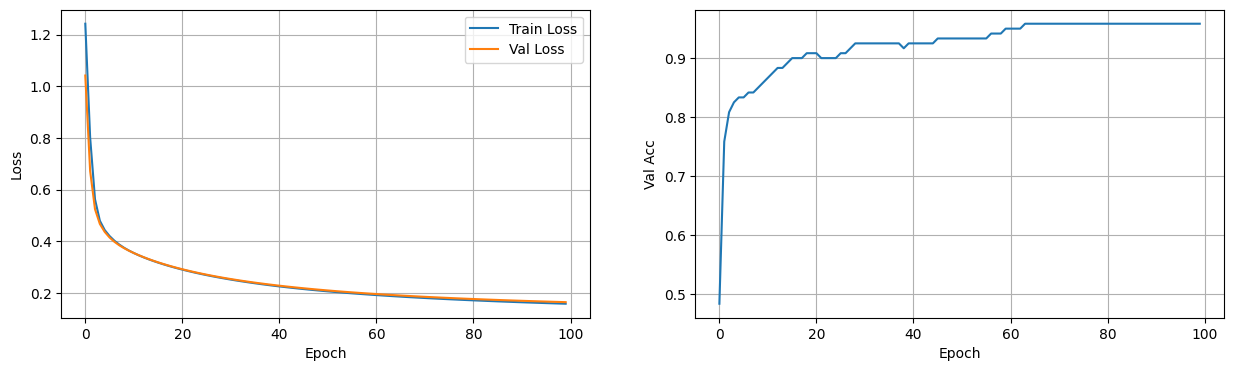

In [5]:
import numpy as np

# 固定隨機種子，確保同參數下每次結果都相同
np.random.seed(1)

with open('../hw2/Iris.csv') as f:
    # 跳過 first row (標籤名稱)
    data = f.readlines()[1:]

data = [line.strip().split(',')[1:] for line in data]
data = np.array(data)
labels = []

classes = np.unique(data[:, 4])

# 將 label 做 one-hot encoding
for d in data:
    for cls in classes:
        if d[4] == cls:
            one_hot = np.zeros(len(classes))
            one_hot[classes.tolist().index(cls)] = 1
            labels.append(one_hot)

# 將 input features 與 labels 從原始資料中分離
inputs = data[:, :4].astype(np.float32)
labels = np.array(labels)

# 對 input features 做標準化
inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)



# 打亂數據
idx = np.random.permutation(len(inputs))

X_data = inputs[idx]

Y_data = labels[idx]

train_size = int(len(X_data) * 0.8)
val_size = len(X_data) - train_size

X_train, Y_train = X_data[:train_size], Y_data[:train_size]
X_val, Y_val = X_data[val_size:], Y_data[val_size:]

hyper_params = {
    'lr': 0.01,
    'epoch': 100,
    'batch_size': 16,
    'alpha': 0.9
}

FOLD = 5


model = MyModel([Linear(4, 3, Softmax)])

params = model.train(X_train, Y_train, X_val, Y_val, CrossEntropyLoss, hyper_params, show_plot=True)
# mlp.kfold(X_data, Y_data, FOLD, SquareLoss, hyper_params)


In [ ]:
a = np.random.randint(0, 255, size=(3, 5, 5))
b = np.random.randint(0, 5, size=(3, 5, 3))

a @ b
a.shape

array([[[ 977, 1753, 1168],
        [ 561,  842,  698],
        [ 603,  794,  752],
        [1143, 2120, 1235],
        [ 585, 1596,  564]],

       [[2881, 1688, 1407],
        [1726, 1035,  918],
        [2461, 1641, 1401],
        [1926,  978,  735],
        [1533, 1034,  906]],

       [[1450, 1562, 1535],
        [ 841,  824,  875],
        [ 551,  781,  643],
        [1210, 1282, 1453],
        [ 721, 1360, 1346]]])